In [8]:
import torch
import torch.nn.functional as F

from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import torchio as tio
import nibabel as nib
import SimpleITK as sitk
from scipy.stats import iqr
from scipy.stats import f_oneway
import multiprocessing as mp

import os
import json
import numpy as np
import copy
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import random

import torchvision
from torchvision import models
from torchvision import transforms

import yaml
from dataset.hmri_dataset import HMRIDataModule, HMRIDataModuleDownstream, HMRIControlsDataModule, HMRIPDDataModule
from models.pl_model import Model, ContrastiveLearning, ModelDownstream
from utils.utils import get_pretrained_model
from utils.utils import save_nifti_from_array, crop_img
from utils.general_utils import save_sitk_from_nda
from tqdm import tqdm
this_path = Path().resolve()

### General statistics (for XAI, qMRI, or RE maps)

In [2]:
def get_statistics_from_map(xai_map: np.ndarray, subject: str, group: str, atlas_type: str = 'synthseg'):
    # get atlas nda
    # atlas_nda = get_atlas_nda(subject, group)
    if atlas_type == 'synthseg':
        atlas_nda = nib.load(f'/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI/{subject}/Results/Masks/ss_cropped_{subject}_mT1w_synthseg.nii').get_fdata()
    if atlas_type == 'pd25':
        atlas_nda = nib.load(f'/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI/{subject}/Results/Masks/T1_R1_SyNRA_CC_pd25T1toR1_warped_atlas.nii').get_fdata()
    # get unique values in atlas
    atlas_vals = np.unique(atlas_nda.astype(int))
    stats = []
    for label in atlas_vals:
        map_stats = {}
        map_stats['label'] = label
        map_stats['group'] = group
        map_stats['atlas'] = atlas_type
        map_stats['subject'] = subject     
        masked_map = xai_map[atlas_nda == label]
        map_stats['volume']= len(masked_map)
        map_stats['mean'] = np.mean(masked_map)
        map_stats['std'] = np.std(masked_map)
        map_stats['median'] = np.median(masked_map)
        map_stats['max'] = np.max(masked_map)
        map_stats['min'] = np.min(masked_map)
        map_stats['iqr'] = iqr(masked_map)
        stats.append(map_stats)

    return pd.DataFrame(stats)

In [5]:
subject = 'sub-015'
# pilot_path = Path(f"/mrhome/alejandrocu/Documents/parkinson_classification/xai_outs/{subject}/occ_sens/4A_hMRI_R2s_WLS1_optim_adam_lr_0.01")
# img_can = nib.load(str(pilot_path/'sub-015_R2s_WLS1_ps5_stride3_og_img.nii.gz')).get_fdata()
img_can = nib.load(Path(f'/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI/sub-015/Results/brain_masked/{subject}_ses-01prisma3t_echo-01_part-magnitude-acq-MToff_MPM_R2s_WLS1_w.nii')).get_fdata()
df = get_statistics_from_map(img_can, subject, 'PD', atlas_type='synthseg')
df['map_type'] = 'R2s'
df

,label,group,atlas,subject,volume,mean,std,median,max,min,iqr,map_type
0,0,PD,synthseg,sub-015,3305244,0.702578,6.635170,0.000000,70.000000,0.000000,0.000000,R2s
1,2,PD,synthseg,sub-015,203253,21.651776,3.410100,21.362673,70.000000,0.000000,3.632734,R2s
2,3,PD,synthseg,sub-015,232178,19.450560,7.516996,19.121547,70.000000,0.000000,5.303693,R2s
3,4,PD,synthseg,sub-015,18167,3.956860,6.332077,1.706614,70.000000,0.000000,4.085211,R2s
4,5,PD,synthseg,sub-015,506,12.524164,12.699727,8.692836,70.000000,0.000000,14.560108,R2s
5,7,PD,synthseg,sub-015,14177,22.088931,4.568679,21.664930,48.213116,3.557872,4.956783,R2s
6,8,PD,synthseg,sub-015,55112,19.560352,10.322278,17.463549,70.000000,0.000000,5.383102,R2s
7,10,PD,synthseg,sub-015,6293,21.351903,4.913520,21.369795,70.000000,0.000000,4.189232,R2s
8,11,PD,synthseg,sub-015,4175,24.550218,7.024254,24.270075,69.689072,2.339174,6.217180,R2s
9,12,PD,synthseg,sub-015,4903,26.737724,6.117193,26.679287,55.716480,10.245028,8.561984,R2s


In [3]:
# stats per qMRI map
root_dir = Path('/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI')
md_df = pd.read_csv(this_path/'bids_3t.csv')
subjs_to_drop = ['sub-058', 'sub-016']
for drop_id in subjs_to_drop:
    md_df.drop(md_df[md_df.id == drop_id].index, inplace=True)
md_df.reset_index(drop=True, inplace=True)

maps = ['MTsat', 'R1', 'R2s_WLS1', 'PD_R2scorr']

dfs = pd.DataFrame()
progress_bar = tqdm(range(len(md_df)), total=len(md_df), desc='Processing maps', ncols=110)
for i in progress_bar:
    subject = md_df['id'][i]
    if md_df['group'][i] == 0:
        group = 'HC'
    else:   
        group = 'PD'
    pilot_path = Path(f'/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI/{subject}/Results')
    for map in maps:
        img_map = nib.load(str(pilot_path/f'brain_masked/{subject}_ses-01prisma3t_echo-01_part-magnitude-acq-MToff_MPM_{map}_w.nii')).get_fdata()
        df = get_statistics_from_map(img_map, subject, group, atlas_type='synthseg')
        df['map_type'] = map
        dfs = pd.concat([dfs, df], axis=0)
dfs.reset_index(drop=True, inplace=True)
# dfs.to_csv('/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/dfs/synthseg_stats.csv', index=False)
dfs

Processing maps: 100%|████████████████████████████████████████████████████████| 70/70 [03:23<00:00,  2.91s/it]


,label,group,atlas,subject,volume,mean,std,median,max,min,iqr,map_type
0,0,PD,synthseg,sub-003,3326168,0.004033,0.059349,0.000000,2.000000,0.000000,0.000000,MTsat
1,2,PD,synthseg,sub-003,203932,1.382839,0.259516,1.431302,2.000000,0.000000,0.318242,MTsat
2,3,PD,synthseg,sub-003,236564,0.776208,0.279045,0.819511,2.000000,0.000000,0.324698,MTsat
3,4,PD,synthseg,sub-003,23593,0.070589,0.123766,0.025063,1.218305,0.000000,0.063837,MTsat
4,5,PD,synthseg,sub-003,951,0.150472,0.163004,0.100461,0.937812,0.000000,0.202447,MTsat
...,...,...,...,...,...,...,...,...,...,...,...,...
9235,52,PD,synthseg,sub-074,1747,75.574689,3.676946,75.369843,90.097977,63.798927,4.595238,PD_R2scorr
9236,53,PD,synthseg,sub-074,4495,78.557350,5.371549,78.796303,120.000000,53.914570,6.623413,PD_R2scorr
9237,54,PD,synthseg,sub-074,2069,79.177872,4.558826,79.045662,99.860344,65.524323,6.162407,PD_R2scorr
9238,58,PD,synthseg,sub-074,722,77.168637,7.328216,76.842819,120.000000,58.141071,7.149042,PD_R2scorr


### Quantiles from HC val distribution

In [2]:
def get_quantiles_from_intensity_distribution(sub_list: list, re_map_type: str, quantiles: list, atlas_labels: list, atlas_type: str = 'pd25'):

    maps = ['MTsat', 'R1', 'R2s_WLS1', 'PD_R2scorr']
    ae_type = ['autoencoder', 'svae', 'vqvae']
    results = []
    re_path = Path('/mrhome/alejandrocu/Documents/parkinson_classification/reconstructions')

    results = []
    for map in maps:
        for ae in ae_type:
            quantiles_dict = {}
            label_quantiles = {label: [] for label in atlas_labels}

            for subject in sub_list:             
                
                # read reconstruction error map
                re_map = nib.load(str(re_path/f'{subject}/{map}/{ae}/odim_{subject}_{re_map_type}.nii')).get_fdata()

                # read atlas
                pilot_path = Path(f'/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI/{subject}/Results')
                if atlas_type == 'synthseg':
                    atlas_path = pilot_path/f'Masks/ss_cropped_{subject}_mT1w_synthseg.nii'
                else:
                    atlas_path = pilot_path/f'Masks/T1_R1_SyNRA_CC_pd25T1toR1_warped_atlas.nii'
                atlas_nda = nib.load(str(atlas_path)).get_fdata().astype(np.uint8)

                for label in atlas_labels:
                    re_map_masked = re_map[atlas_nda == label]
                    # print(f'{subject}, {ae}, {map}, {label}, {len(re_map_masked)}')
                    label_quantiles[label].extend(re_map_masked.flatten())
            
            for label in atlas_labels:
                quantiles_dict['atlas'] = atlas_type
                quantiles_dict['atlas_label'] = label
                # print(f'{label}, {len(label_quantiles[label])}')
                quantiles_res = np.quantile(label_quantiles[label], 
                                                          quantiles,
                                                          method='midpoint')
                for i, quant in enumerate(quantiles):
                    quantiles_dict[f'q{quant}'] = quantiles_res[i]
                quantiles_dict['map'] = map
                quantiles_dict['ae'] = ae
                results.append(quantiles_dict.copy())

    return pd.DataFrame(results)

In [3]:
# read atlas
subject = 'sub-015'
pilot_path = Path(f'/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI/{subject}/Results')
atlas_path = pilot_path/f'Masks/ss_cropped_{subject}_mT1w_synthseg.nii'
atlas_nda = nib.load(str(atlas_path)).get_fdata().astype(np.uint8)
atlas_labels = np.unique(atlas_nda)[1:]
print(atlas_labels)

[ 2  3  4  5  7  8 10 11 12 13 14 15 16 17 18 24 26 28 41 42 43 44 46 47
 49 50 51 52 53 54 58 60]


In [3]:
subjects_list = ['sub-044', 'sub-050', 'sub-036', 'sub-030', 'sub-057', 'sub-069', 'sub-028']
atlas_labels = [1,2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
quantiles = [0.8, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94,  0.96, 0.98, 0.99, 1.0]
atlases = ['pd25'] #, 'pd25'
re_map_types = ['l1_re_map', 'l2_re_map', 'mse_re_map', 'ssim_re_map']
for atlas in atlases:
    for re_map in re_map_types:
        print(f'Processing {atlas} {re_map}')
        df = get_quantiles_from_intensity_distribution(subjects_list, 
                                                    re_map, 
                                                    quantiles, 
                                                    atlas_labels, 
                                                    atlas_type=atlas)
        df.to_csv(f'/mrhome/alejandrocu/Documents/parkinson_classification/reconstructions/quantiles_hc_val_{atlas}_{re_map}.csv', 
                index=False)

Processing pd25 l1_re_map
Processing pd25 l2_re_map
Processing pd25 mse_re_map
Processing pd25 ssim_re_map


In [13]:
df #.to_csv('/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/dfs/hc_val_pd25_quantiles_l1_re_map.csv', index=False)

,atlas,atlas_label,q0.8,q0.82,q0.84,q0.86,q0.88,q0.9,q0.92,q0.94,q0.96,q0.98,q0.99,q1.0,map,ae
0,pd25,1,0.083024,0.085992,0.090117,0.095430,0.100426,0.106185,0.113015,0.120793,0.129319,0.147103,0.167797,0.201026,MTsat,autoencoder
1,pd25,2,0.076229,0.079638,0.083440,0.088254,0.093870,0.099415,0.103763,0.110620,0.121306,0.135051,0.148066,0.199486,MTsat,autoencoder
2,pd25,3,0.092620,0.096834,0.101040,0.106746,0.112673,0.117904,0.124177,0.136031,0.147270,0.171155,0.190763,0.267147,MTsat,autoencoder
3,pd25,4,0.084540,0.088194,0.092379,0.097676,0.103456,0.109150,0.117020,0.125408,0.138211,0.156036,0.173776,0.277429,MTsat,autoencoder
4,pd25,5,0.092654,0.097130,0.101276,0.105504,0.110698,0.115617,0.120514,0.130292,0.139526,0.152111,0.167157,0.233044,MTsat,autoencoder
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,pd25,12,0.055691,0.057483,0.059331,0.061413,0.063401,0.065873,0.068462,0.071830,0.076473,0.084292,0.091873,0.149972,PD_R2scorr,vqvae
188,pd25,13,0.053591,0.055482,0.057485,0.059642,0.061745,0.064003,0.066878,0.070213,0.075893,0.084823,0.091858,0.206226,PD_R2scorr,vqvae
189,pd25,14,0.054594,0.056306,0.058027,0.059787,0.062358,0.064337,0.067422,0.070788,0.075799,0.083136,0.090979,0.115741,PD_R2scorr,vqvae
190,pd25,15,0.054352,0.056020,0.057997,0.059990,0.062358,0.064976,0.068006,0.071998,0.077466,0.086945,0.097578,0.292379,PD_R2scorr,vqvae


In [4]:
# # create full csv files
# re_map_types = ['l1_re_map', 'l2_re_map', 'mse_re_map', 'ssim_re_map']
# atlases = ['synthseg', 'pd25']
# for atlas in atlases:
#     df = pd.DataFrame()
#     for re_map in re_map_types:
#         df_tmp = pd.read_csv(f'/mrhome/alejandrocu/Documents/parkinson_classification/reconstructions/quantiles_hc_val_{atlas}_{re_map}.csv')
#         df_tmp['re_map'] = re_map
#         df = pd.concat([df, df_tmp], axis=0)
#     df.to_csv(f'/mrhome/alejandrocu/Documents/parkinson_classification/reconstructions/quantiles_hc_val_{atlas}.csv', index=False)

In [16]:
df_tmp = df.loc[(df.map == 'MTsat') & (df.ae == 'autoencoder') & (df.re_map == 'l1_re_map'), :]
df_tmp.loc[:, 'q0.8':'q1.0'].values[0]

array([0.08302408, 0.08599168, 0.09011695, 0.09543009, 0.10042623,
       0.10618517, 0.1130154 , 0.12079322, 0.12931946, 0.14710259,
       0.16779658, 0.20102626])

### Anomaly percentages

In [2]:
# get anomaly percentages
def get_anomaly_percentages(subject, atlas_type='synthseg'): 
    re_path = Path('/mrhome/alejandrocu/Documents/parkinson_classification/reconstructions/')
    pilot_path = Path(f'/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI/{subject}/Results')
    if atlas_type == 'pd25':
        pd_atlas_path = pilot_path/f'Masks/T1_R1_SyNRA_CC_pd25T1toR1_warped_atlas.nii'
        df_quantiles = pd.read_csv(re_path/'quantiles_hc_val_pd25.csv')
    else:
        pd_atlas_path = pilot_path/f'Masks/ss_cropped_{subject}_mT1w_synthseg.nii'
        df_quantiles = pd.read_csv(re_path/'quantiles_hc_val_synthseg.csv')

    pd_atlas_nda = nib.load(str(pd_atlas_path)).get_fdata().astype(np.uint8)

    maps = ['MTsat', 'R1', 'R2s_WLS1', 'PD_R2scorr']
    ae_type = ['autoencoder', 'svae', 'vqvae']
    re_map_types = ['l1_re_map', 'l2_re_map', 'mse_re_map', 'ssim_re_map']
    quantiles = ['q0.8',  'q0.82', 'q0.84', 'q0.86', 'q0.88', 'q0.9', 'q0.92', 'q0.94', 'q0.96', 'q0.98', 'q0.99', 'q1.0']
    results = []
    for map in maps:
        for ae in ae_type:
            for re_map_type in re_map_types:
                subj_re_map = nib.load(str(re_path/f'{subject}/{map}/{ae}/odim_{subject}_{re_map_type}.nii')).get_fdata()
                # print(f'Processing {map} {ae} {re_map_type}')
                df_tmp = df_quantiles.loc[(df_quantiles.map == map) & (df_quantiles.ae == ae) & (df_quantiles.re_map == re_map_type), :]

                for i in range(len(df_tmp)):
                    label = df_tmp.atlas_label.values[i]
                    for quant in quantiles:
                        anomaly_results = {}
                        quantile = df_tmp.loc[:, quant].values[i]
                        roi_voxels = subj_re_map[pd_atlas_nda == label]
                        anomaly_voxels = roi_voxels[roi_voxels > quantile]
                        anomaly_percentage = len(anomaly_voxels)/len(roi_voxels)
                        anomaly_results['label'] = label
                        anomaly_results['atlas'] = atlas_type
                        anomaly_results['map'] = map
                        anomaly_results['ae'] = ae
                        anomaly_results['re_map'] = re_map_type
                        anomaly_results['quantile'] = quant
                        anomaly_results['anomaly_percentage'] = anomaly_percentage
                        results.append(anomaly_results)
                        
    return pd.DataFrame(results), subject

In [3]:
# create datasets
ckpt_path = Path('/mrhome/alejandrocu/Documents/parkinson_classification/vqvae_models/normative_vqvae_run3_R2s_WLS1/config_dump.yml')
with open(ckpt_path, 'r') as f:
    exp_cfg = list(yaml.load_all(f, yaml.SafeLoader))[0]
    
root_dir = Path('/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI')
md_df = pd.read_csv(this_path/'bids_3t.csv')
md_df_hc = md_df[md_df['group'] == 0]
md_df_pd = md_df[md_df['group'] == 1]

map_type = exp_cfg['dataset']['map_type']
augmentations = tio.Compose([])
data_hc = HMRIControlsDataModule(md_df=md_df_hc,
                        root_dir=root_dir,
                        augment=augmentations,
                        **exp_cfg['dataset'])
data_hc.prepare_data()
data_hc.setup()

data_pd = HMRIPDDataModule(md_df=md_df_pd,
                            root_dir=root_dir,
                            augment=augmentations,
                            **exp_cfg['dataset'])
data_pd.prepare_data()
data_pd.setup()

print(f'PD subjects: {len(data_pd.md_df)}, HC val subjects: {len(data_hc.md_df_val)}')

n_jobs = mp.cpu_count()
print(f'Avaliable cores: {n_jobs}')

PD subjects: 47, HC val subjects: 7


In [ ]:
atlas_type = 'synthseg'
n_jobs = mp.cpu_count()
print(f'Avaliable cores: {n_jobs}')

sub_results_path = Path('/mrhome/alejandrocu/Documents/parkinson_classification/reconstructions')
subjects = data_pd.md_df.id.values.tolist()
with mp.Pool(20) as pool:
    for rdf, sub in pool.map(get_anomaly_percentages, subjects):
        print(sub)
        rdf.to_csv(sub_results_path/f'{sub}/{sub}_anomaly_percentages_{atlas_type}.csv', index=False)

# for i in range(len(data_hc.md_df_val)):
#     subject = data_hc.md_df_val['id'][i]
#     print(f'Processing {subject}')
#     rdf = get_anomaly_percentages(subject, atlas_type=atlas_type)
#     sub_results_path = Path('/mrhome/alejandrocu/Documents/parkinson_classification/reconstructions')
#     rdf.to_csv(sub_results_path/f'{subject}/{subject}_anomaly_percentages_{atlas_type}.csv', index=False)

<Axes: xlabel='anomaly_percentage', ylabel='Count'>

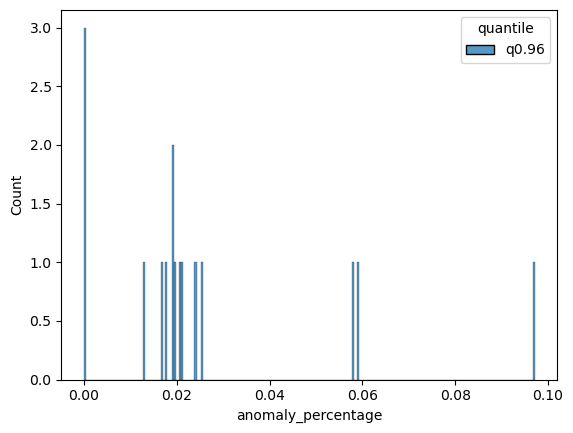

In [65]:
df_plot = results_df.loc[(results_df.map == 'MTsat') & (results_df.ae == 'autoencoder') & (results_df.re_map == 'l1_re_map') , :] # & (results_df.label == 3)
sns.histplot(data=df_plot, x='anomaly_percentage', hue='quantile', multiple='stack', bins=200)
# plt.xlim(0, 0.25)

### ROC Curves

In [ ]:
# def stratified_sample_df(df, col, n_samples):
#     n = min(n_samples, df[col].value_counts().min())
#     df_ = df.groupby(col).apply(lambda x: x.sample(n))
#     df_.index = df_.index.droplevel(0)
#     return df_


In [6]:
7 * (14/5)

19.599999999999998

In [76]:
# create datasets
ckpt_path = Path('/mrhome/alejandrocu/Documents/parkinson_classification/vqvae_models/normative_vqvae_run3_R2s_WLS1/config_dump.yml')
with open(ckpt_path, 'r') as f:
    exp_cfg = list(yaml.load_all(f, yaml.SafeLoader))[0]
    
root_dir = Path('/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI')
md_df = pd.read_csv(this_path/'bids_3t.csv')
md_df_hc = md_df[md_df['group'] == 0]
md_df_pd = md_df[md_df['group'] == 1]

map_type = exp_cfg['dataset']['map_type']
augmentations = tio.Compose([])
data_hc = HMRIControlsDataModule(md_df=md_df_hc,
                        root_dir=root_dir,
                        augment=augmentations,
                        **exp_cfg['dataset'])
data_hc.prepare_data()
data_hc.setup()

data_pd = HMRIPDDataModule(md_df=md_df_pd,
                            root_dir=root_dir,
                            augment=augmentations,
                            **exp_cfg['dataset'])
data_pd.prepare_data()
data_pd.setup()

print(f'PD subjects: {len(data_pd.md_df)}, HC val subjects: {len(data_hc.md_df_val)}')
pd_subjects = data_pd.md_df.id.values.tolist()
hc_val_subjects = data_hc.md_df_val.id.values.tolist()

PD subjects: 47, HC val subjects: 7


In [7]:
data_pd.md_df.columns

Index(['id', 's01-7t', 's01-3t', 's02-7t', 's03-7t', 'group', 'sex', 'age'], dtype='object')

In [113]:
def sample_patients(patients, controls, num_samples, age_tolerance=1):
    control_mean_age = np.mean(controls.age.values.tolist())
    patient_list = patients.id.values.tolist()
    sampled_patients = []
    while len(sampled_patients) < num_samples:
        patient_idx = random.randrange(len(patient_list))
        patient = patient_list[patient_idx]
        patient_age = patients.loc[patients.id == patient, 'age'].values[0] # Assuming patient list is a list of dictionaries with 'age' and 'sex' as keys
        patient_sex = patients.loc[patients.id == patient, 'sex'].values[0]

        # Filter controls by sex
        filtered_controls = [control for _, control in controls.iterrows() if control['sex'] == patient_sex]

        # Calculate mean age for filtered controls
        filtered_controls_mean_age = np.mean(pd.DataFrame(filtered_controls).age.values.tolist())

        # Accept patients within 1 year of the filtered controls mean age
        if abs(patient_age - control_mean_age) <= age_tolerance:
            sampled_patients.append(patient)
            patient_list.pop(patient_idx)

    return sampled_patients

def sample_patients_without_replacement(patients, controls, num_samples, age_tolerance=1):
    control_mean_age = np.mean(controls.age.values.tolist())
    patient_list = patients.id.values.tolist()
    sampled_patients = []
    
    # Calculate sex frequency ratio in controls
    control_sex_counts = controls.sex.value_counts().to_dict()
    
    # Initialize sex count for sampled patients
    sampled_sex_counts = {sex: 0 for sex in control_sex_counts.keys()}
    
    while len(sampled_patients) < num_samples:
        patient_idx = random.randrange(len(patient_list))
        patient = patient_list[patient_idx]
        patient_age = patients.loc[patients.id == patient, 'age'].values[0]
        patient_sex = patients.loc[patients.id == patient, 'sex'].values[0]

        # Filter controls by sex
        filtered_controls = controls[controls['sex'] == patient_sex]

        # Calculate mean age for filtered controls
        filtered_controls_mean_age = np.mean(filtered_controls.age.values.tolist())

        # Accept patients within the specified age tolerance of the filtered controls mean age
        if abs(patient_age - filtered_controls_mean_age) <= age_tolerance and sampled_sex_counts[patient_sex] < control_sex_counts[patient_sex]:
            sampled_patients.append(patient)
            sampled_sex_counts[patient_sex] += 1
            controls = controls.drop(filtered_controls.index)
            patient_list.pop(patient_idx)

    return sampled_patients

In [62]:
# subsample PD subjects matching sex and mean age of HC val
md_df_hc_val = data_hc.md_df_val
md_df_pd = data_pd.md_df

print(md_df_hc_val.sex.value_counts())
print(md_df_hc_val.age.mean())

0    5
1    2
Name: sex, dtype: int64
66.85714285714286


In [68]:
sampled_ids = sample_patients(md_df_pd, md_df_hc_val, 20, age_tolerance=7)
sampled_pd_df = md_df_pd.loc[md_df_pd.id.isin(sampled_ids), :]
print(sampled_pd_df.sex.value_counts())
print(sampled_pd_df.age.mean())

0    12
1     8
Name: sex, dtype: int64
65.5


In [122]:
sampled_ids = sample_patients(md_df_pd, md_df_hc_val, 20, age_tolerance=7)
sampled_pd_df = md_df_pd.loc[md_df_pd.id.isin(sampled_ids), :]
print(sampled_pd_df.sex.value_counts())
print(sampled_pd_df.age.mean())

0    14
1     6
Name: sex, dtype: int64
67.55


In [123]:
print(sampled_ids)

['sub-006', 'sub-025', 'sub-014', 'sub-019', 'sub-011', 'sub-049', 'sub-024', 'sub-004', 'sub-018', 'sub-008', 'sub-003', 'sub-023', 'sub-035', 'sub-065', 'sub-061', 'sub-015', 'sub-029', 'sub-043', 'sub-071', 'sub-056']


In [158]:
from sklearn import metrics

hc_val_subjects = data_hc.md_df_val.id.values.tolist()
pd_subjects = sampled_pd_df.id.values.tolist()

# select an experiment
map_type = 'MTsat'
ae_type = 'autoencoder'
re_map_type = 'ssim_re_map'
atlas_type = 'pd25'
quantiles = ['q0.8',  'q0.82', 'q0.84', 'q0.86', 'q0.88', 'q0.9', 'q0.92', 'q0.94', 'q0.96', 'q0.98', 'q0.99']

subject = 'sub-015'
sub_results_path = Path('/mrhome/alejandrocu/Documents/parkinson_classification/reconstructions')
pilot_path = Path(f'/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI/{subject}/Results')
if atlas_type == 'pd25':
    pd_atlas_path = pilot_path/f'Masks/T1_R1_SyNRA_CC_pd25T1toR1_warped_atlas.nii'
else:
    pd_atlas_path = pilot_path/f'Masks/ss_cropped_{subject}_mT1w_synthseg.nii'

atlas_labels = np.unique(nib.load(str(pd_atlas_path)).get_fdata().astype(np.uint8))[1:]

scores = {label: {quant: [] for quant in quantiles} for label in atlas_labels}
targets = []
for subject in hc_val_subjects:
    # print(f'Processing {subject}')
    df = pd.read_csv(sub_results_path/f'{subject}/{subject}_anomaly_percentages_{atlas_type}.csv')
    sub_df = df.loc[(df.map == map_type) & (df.ae == ae_type) & (df.re_map == re_map_type), :]
    for label in atlas_labels:
            for quant in quantiles:
                lab_df = sub_df.loc[sub_df.label == label, :]
                scores[label][quant].append(lab_df.loc[lab_df['quantile'] == quant, 'anomaly_percentage'].values[0])
    targets.append(0)
    
for subject in pd_subjects:
    # print(f'Processing {subject}')
    df = pd.read_csv(sub_results_path/f'{subject}/{subject}_anomaly_percentages_{atlas_type}.csv')
    sub_df = df.loc[(df.map == map_type) & (df.ae == ae_type) & (df.re_map == re_map_type), :]
    for label in atlas_labels:
            for quant in quantiles:
                lab_df = sub_df.loc[sub_df.label == label, :]
                scores[label][quant].append(lab_df.loc[lab_df['quantile'] == quant, 'anomaly_percentage'].values[0])
    targets.append(1)

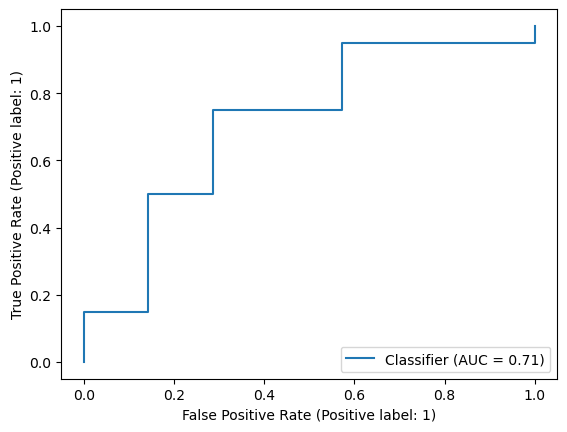

In [94]:
metrics.RocCurveDisplay.from_predictions(targets, 
                                         scores[12]['q0.82'],
                                         pos_label=1,
                                         drop_intermediate=True)
plt.show()

metrics.PrecisionRecallDisplay.from_predictions(targets,
                                                scores[12]['q0.82'],
                                                pos_label=1)
plt.show()

In [159]:
# compute performance metrics
class_results = [] #{label: {quant: [] for quant in quantiles} for label in atlas_labels}
for label, quant_scores in scores.items():
    for quant, subj_scores in quant_scores.items():
        res = {}
        fpr, tpr, thresholds = metrics.roc_curve(targets, subj_scores, pos_label=1)
        g_means = np.sqrt(tpr * (1-fpr))
        precision, recall, _ = metrics.precision_recall_curve(targets, subj_scores, pos_label=1)
        roc_auc = metrics.auc(fpr, tpr)
        prc_auc = metrics.auc(recall, precision)
        res['label'] = label
        res['quant'] = quant
        res['fpr'] = fpr
        res['tpr'] = tpr
        res['auroc'] = roc_auc
        res['g_means'] = g_means
        res['gmean'] = np.max(g_means)
        res['precision'] = precision
        res['recall'] = recall
        res['auprc'] = prc_auc
        class_results.append(res)

class_results = pd.DataFrame(class_results)
class_results

,label,quant,fpr,tpr,auroc,g_means,gmean,precision,recall,auprc
0,1,q0.8,"[0.0, 0.0, 0.0, 0.14285714285714285, 0.1428571...","[0.0, 0.05, 0.2, 0.2, 0.45, 0.45, 0.5, 0.5, 0....",0.600000,"[0.0, 0.22360679774997896, 0.4472135954999579,...",0.621059,"[0.7407407407407407, 0.7307692307692307, 0.72,...","[1.0, 0.95, 0.9, 0.9, 0.85, 0.85, 0.8, 0.75, 0...",0.835376
1,1,q0.82,"[0.0, 0.0, 0.0, 0.14285714285714285, 0.1428571...","[0.0, 0.05, 0.2, 0.2, 0.45, 0.45, 0.5, 0.5, 0....",0.600000,"[0.0, 0.22360679774997896, 0.4472135954999579,...",0.621059,"[0.7407407407407407, 0.7307692307692307, 0.72,...","[1.0, 0.95, 0.9, 0.9, 0.85, 0.85, 0.8, 0.75, 0...",0.835376
2,1,q0.84,"[0.0, 0.0, 0.0, 0.14285714285714285, 0.1428571...","[0.0, 0.05, 0.2, 0.2, 0.5, 0.5, 0.65, 0.65, 0....",0.585714,"[0.0, 0.22360679774997896, 0.4472135954999579,...",0.654654,"[0.7407407407407407, 0.7307692307692307, 0.72,...","[1.0, 0.95, 0.9, 0.9, 0.85, 0.85, 0.8, 0.75, 0...",0.831683
3,1,q0.86,"[0.0, 0.0, 0.0, 0.14285714285714285, 0.1428571...","[0.0, 0.05, 0.2, 0.2, 0.45, 0.45, 0.5, 0.5, 0....",0.571429,"[0.0, 0.22360679774997896, 0.4472135954999579,...",0.621059,"[0.7407407407407407, 0.7307692307692307, 0.72,...","[1.0, 0.95, 0.9, 0.9, 0.85, 0.85, 0.8, 0.75, 0...",0.826013
4,1,q0.88,"[0.0, 0.0, 0.0, 0.14285714285714285, 0.1428571...","[0.0, 0.05, 0.1, 0.1, 0.35, 0.35, 0.5, 0.5, 0....",0.557143,"[0.0, 0.22360679774997896, 0.31622776601683794...",0.597614,"[0.7407407407407407, 0.7307692307692307, 0.72,...","[1.0, 0.95, 0.9, 0.9, 0.9, 0.85, 0.8, 0.75, 0....",0.794645
...,...,...,...,...,...,...,...,...,...,...
171,16,q0.92,"[0.0, 0.0, 0.0, 0.14285714285714285, 0.1428571...","[0.0, 0.05, 0.2, 0.2, 0.25, 0.25, 0.3, 0.3, 0....",0.550000,"[0.0, 0.22360679774997896, 0.4472135954999579,...",0.585540,"[0.7407407407407407, 0.7692307692307693, 0.76,...","[1.0, 1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.75, 0...",0.802237
172,16,q0.94,"[0.0, 0.0, 0.0, 0.2857142857142857, 0.28571428...","[0.0, 0.05, 0.25, 0.25, 0.35, 0.35, 0.6, 0.6, ...",0.564286,"[0.0, 0.22360679774997896, 0.5, 0.422577127364...",0.585540,"[0.7407407407407407, 0.7692307692307693, 0.76,...","[1.0, 1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.75, 0...",0.815432
173,16,q0.96,"[0.0, 0.0, 0.0, 0.14285714285714285, 0.1428571...","[0.0, 0.05, 0.25, 0.25, 0.3, 0.3, 0.4, 0.4, 0....",0.585714,"[0.0, 0.22360679774997896, 0.5, 0.462910049886...",0.585540,"[0.7407407407407407, 0.7692307692307693, 0.76,...","[1.0, 1.0, 0.95, 0.9, 0.85, 0.8, 0.8, 0.8, 0.7...",0.825987
174,16,q0.98,"[0.0, 0.0, 0.0, 0.14285714285714285, 0.1428571...","[0.0, 0.05, 0.25, 0.25, 0.3, 0.3, 0.45, 0.45, ...",0.614286,"[0.0, 0.22360679774997896, 0.5, 0.462910049886...",0.609449,"[0.7407407407407407, 0.7692307692307693, 0.76,...","[1.0, 1.0, 0.95, 0.9, 0.85, 0.85, 0.8, 0.8, 0....",0.836220


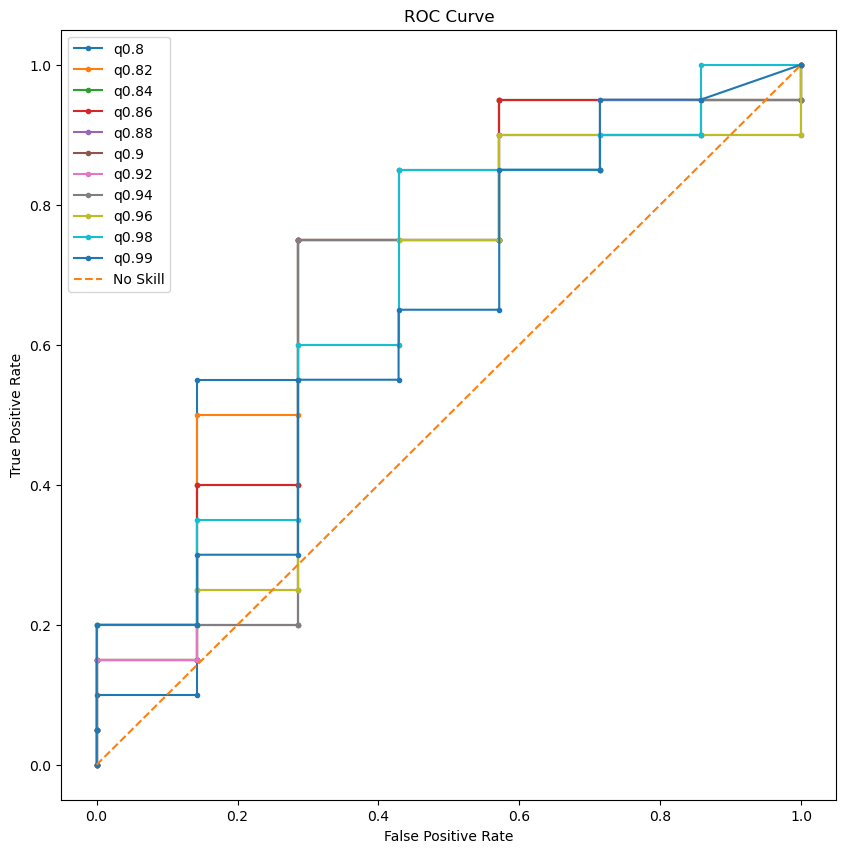

In [124]:
# plot the roc curve for the model
quantiles = ['q0.8',  'q0.82', 'q0.84', 'q0.86', 'q0.88', 'q0.9', 'q0.92', 'q0.94', 'q0.96', 'q0.98', 'q0.99']
f = plt.figure(figsize=(10,10))
for quant in quantiles:
    fpr = class_results.loc[(class_results.label == 12) & (class_results.quant == quant), 'fpr'].values[0]
    tpr = class_results.loc[(class_results.label == 12) & (class_results.quant == quant), 'tpr'].values[0]
    plt.plot(fpr, tpr, marker='.', label=quant)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
# show the plot
plt.show()

[0.         0.14285714 0.14285714 0.28571429 0.28571429 0.42857143
 0.42857143 0.57142857 0.57142857 0.71428571 0.71428571 0.85714286
 0.85714286 1.         1.        ]
[0.   0.   0.1  0.1  0.35 0.35 0.5  0.5  0.6  0.6  0.8  0.8  0.95 0.95
 1.  ]


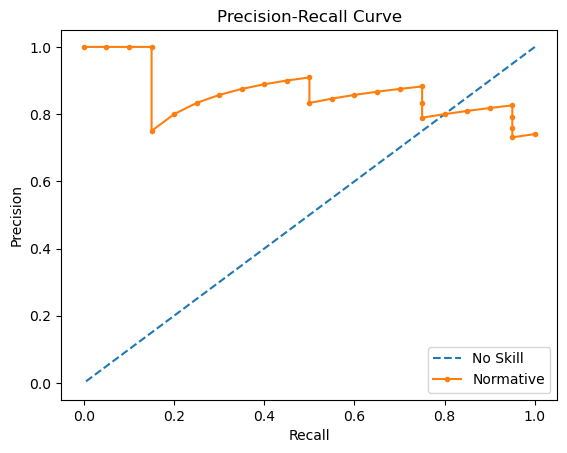

In [106]:
# plot the roc curve for the model
precision = class_results.loc[(class_results.label == 12) & (class_results.quant == 'q0.82'), 'precision'].values[0]
print(fpr)
recall = class_results.loc[(class_results.label == 12) & (class_results.quant == 'q0.82'), 'recall'].values[0]
print(tpr)
plt.plot([1,0], [1,0], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Normative')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall Curve')
# show the plot
plt.show()

In [160]:
class_results.sort_values(by='auroc', ascending=False)

,label,quant,fpr,tpr,auroc,g_means,gmean,precision,recall,auprc
142,13,q0.99,"[0.0, 0.0, 0.0, 0.14285714285714285, 0.1428571...","[0.0, 0.05, 0.5, 0.5, 0.7, 0.7, 0.8, 0.8, 0.9,...",0.814286,"[0.0, 0.22360679774997896, 0.7071067811865476,...",0.774597,"[0.7407407407407407, 0.782608695652174, 0.8181...","[1.0, 0.9, 0.9, 0.9, 0.85, 0.8, 0.8, 0.75, 0.7...",0.933840
132,13,q0.8,"[0.0, 0.0, 0.0, 0.14285714285714285, 0.1428571...","[0.0, 0.05, 0.45, 0.45, 0.6, 0.6, 0.8, 0.8, 0....",0.778571,"[0.0, 0.22360679774997896, 0.6708203932499369,...",0.755929,"[0.7407407407407407, 0.7307692307692307, 0.76,...","[1.0, 0.95, 0.95, 0.95, 0.9, 0.85, 0.85, 0.85,...",0.919047
140,13,q0.96,"[0.0, 0.0, 0.0, 0.2857142857142857, 0.28571428...","[0.0, 0.05, 0.55, 0.55, 0.65, 0.75, 0.75, 0.9,...",0.778571,"[0.0, 0.22360679774997896, 0.7416198487095663,...",0.741620,"[0.7407407407407407, 0.7307692307692307, 0.72,...","[1.0, 0.95, 0.9, 0.9, 0.9, 0.9, 0.9, 0.85, 0.8...",0.923053
134,13,q0.84,"[0.0, 0.0, 0.0, 0.14285714285714285, 0.1428571...","[0.0, 0.05, 0.45, 0.45, 0.6, 0.6, 0.8, 0.8, 0....",0.778571,"[0.0, 0.22360679774997896, 0.6708203932499369,...",0.755929,"[0.7407407407407407, 0.7307692307692307, 0.76,...","[1.0, 0.95, 0.95, 0.95, 0.9, 0.85, 0.85, 0.85,...",0.919047
136,13,q0.88,"[0.0, 0.0, 0.0, 0.2857142857142857, 0.28571428...","[0.0, 0.05, 0.55, 0.55, 0.7, 0.7, 0.85, 0.85, ...",0.771429,"[0.0, 0.22360679774997896, 0.7416198487095663,...",0.741620,"[0.7407407407407407, 0.7307692307692307, 0.76,...","[1.0, 0.95, 0.95, 0.9, 0.9, 0.9, 0.85, 0.85, 0...",0.920060
...,...,...,...,...,...,...,...,...,...,...
124,12,q0.86,"[0.0, 0.0, 0.0, 0.42857142857142855, 0.4285714...","[0.0, 0.05, 0.1, 0.1, 0.25, 0.25, 0.3, 0.3, 0....",0.292857,"[0.0, 0.22360679774997896, 0.31622776601683794...",0.396412,"[0.7407407407407407, 0.7307692307692307, 0.72,...","[1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0...",0.675867
127,12,q0.92,"[0.0, 0.0, 0.0, 0.5714285714285714, 0.57142857...","[0.0, 0.05, 0.1, 0.1, 0.5, 0.5, 0.65, 0.65, 1.0]",0.292857,"[0.0, 0.22360679774997896, 0.31622776601683794...",0.462910,"[0.7407407407407407, 0.7307692307692307, 0.72,...","[1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0...",0.673511
128,12,q0.94,"[0.0, 0.0, 0.0, 0.5714285714285714, 0.57142857...","[0.0, 0.05, 0.1, 0.1, 0.5, 0.5, 0.55, 0.55, 1.0]",0.278571,"[0.0, 0.22360679774997896, 0.31622776601683794...",0.462910,"[0.7407407407407407, 0.7307692307692307, 0.72,...","[1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0...",0.670002
126,12,q0.9,"[0.0, 0.0, 0.0, 0.5714285714285714, 0.57142857...","[0.0, 0.05, 0.1, 0.1, 0.35, 0.35, 0.5, 0.5, 0....",0.271429,"[0.0, 0.22360679774997896, 0.31622776601683794...",0.387298,"[0.7407407407407407, 0.7307692307692307, 0.72,...","[1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0...",0.665958


<Axes: xlabel='label', ylabel='gmean'>

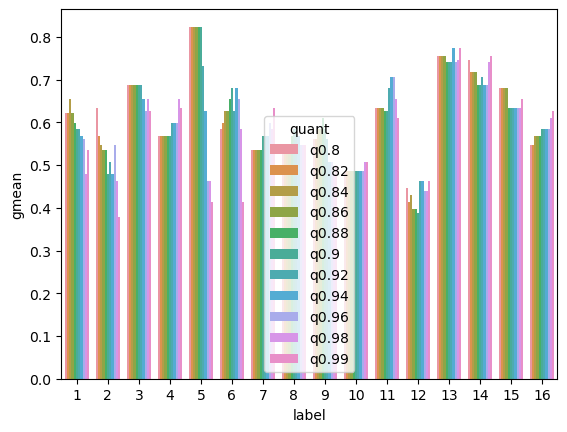

In [161]:
sns.barplot(x='label', y='gmean', hue='quant', data=class_results) # .loc[class_results.auroc > 0.6, :] 

<Axes: xlabel='quant', ylabel='gmean'>

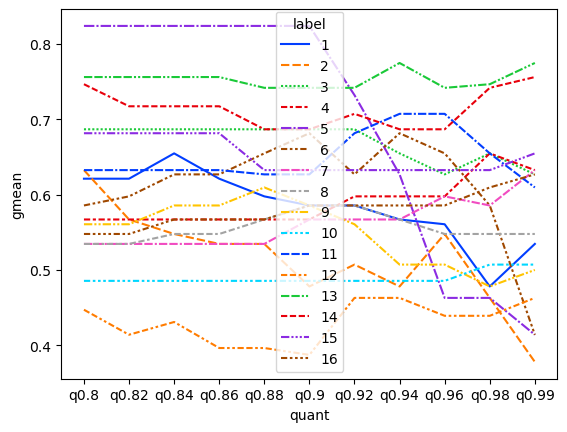

In [162]:
results_to_plot = class_results #.loc[class_results.label == 12, :]
# sns.lineplot(x='quant', y='auroc', data=results_to_plot, legend='full', hue='label', style='label',palette='bright') # style='label',  palette='Spectral
sns.lineplot(x='quant', y='gmean', data=results_to_plot, legend='full', hue='label',style='label',palette='bright') # style='label',  palette='Spectral

<Axes: xlabel='quant', ylabel='gmean'>

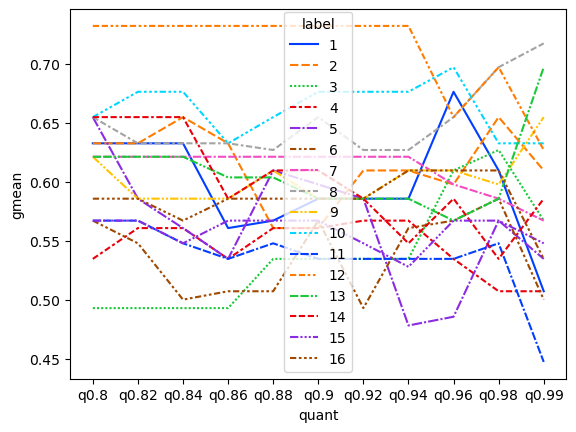

In [152]:
esults_to_plot = class_results #.loc[class_results.label == 12, :]
# sns.lineplot(x='quant', y='auroc', data=results_to_plot, legend='full', hue='label', style='label',palette='bright') # style='label',  palette='Spectral
sns.lineplot(x='quant', y='gmean', data=results_to_plot, legend='full', hue='label',style='label',palette='bright') # style='label',  palette='Spectral

### Dev

In [65]:
# subjs = {'sub-041': 'PD',
#          'sub-036': 'HC',
#          'sub-035': 'PD',
#          'sub-071': 'PD',
#          'sub-030': 'HC',
#          'sub-015': 'PD',
#          'sub-032': 'HC',
#          'sub-050': 'HC'}
subjs = {'sub-021': 'PD',
         'sub-064': 'HC',
         'sub-042': 'PD',
         'sub-066': 'PD',
         'sub-039': 'PD'}

maps = ['r2s', 'occ', 'ig']
dfs = pd.DataFrame()
for subject, group in subjs.items():
    for xai_map in maps:
        base_path = Path(f'/mrhome/alejandrocu/Documents/parkinson_classification/xai_outs/{subject}')
        if xai_map == 'r2s':
            map_path = base_path / f'occ_sens/4A_hMRI_R2s_WLS1_optim_adam_lr_0.01/{subject}_R2s_WLS1_ps5_stride3_og_img.nii.gz'
        elif xai_map == 'occ':
            map_path = base_path / f'occ_sens/4A_hMRI_R2s_WLS1_optim_adam_lr_0.01/{subject}_R2s_WLS1_ps5_stride3_occ_result.nii.gz'
        elif xai_map == 'ig':
            map_path = base_path / f'grad_based/4A_hMRI_R2s_WLS1_optim_adam_lr_0.01/{subject}_R2s_WLS1_IntegratedGrads_nsteps_200_result.nii.gz'
        map_img = nib.load(str(map_path)).get_fdata()
        df = get_statistics_from_map(map_img, subject, group, atlas_type='synthseg')
        df['map_type'] = xai_map
        dfs = pd.concat([dfs, df], axis=0)
    # break
dfs.reset_index(drop=True, inplace=True)
dfs


,label,group,subject,mean,std,median,max,min,iqr,map_type
0,0,PD,sub-021,0.073175,0.159834,0.000000,1.000000,0.000000,0.000000,r2s
1,1,PD,sub-021,0.556251,0.137773,0.540562,0.972508,0.311592,0.172323,r2s
2,2,PD,sub-021,0.589647,0.124017,0.571411,0.943677,0.341132,0.168418,r2s
3,3,PD,sub-021,0.657735,0.220869,0.630668,1.000000,0.190870,0.384007,r2s
4,4,PD,sub-021,0.689894,0.267532,0.731393,1.000000,0.137779,0.535777,r2s
...,...,...,...,...,...,...,...,...,...,...
250,12,PD,sub-039,0.000010,0.000008,0.000008,0.000053,-0.000002,0.000010,ig
251,13,PD,sub-039,-0.000002,0.000003,-0.000001,0.000008,-0.000021,0.000004,ig
252,14,PD,sub-039,0.000004,0.000003,0.000003,0.000017,-0.000002,0.000005,ig
253,15,PD,sub-039,-0.000003,0.000003,-0.000002,0.000005,-0.000027,0.000003,ig


In [96]:
# df_ex = pd.read_csv('xai_outs/stats_5subjs_others.csv')
# df_ex.drop('Unnamed: 0', axis=1, inplace=True)
# df_ex.to_csv('xai_outs/stats_5subjs_others.csv', index=False)

/tmp/ipykernel_550499/1739611130.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_uncertain['subgroup'] = 'uncertain'


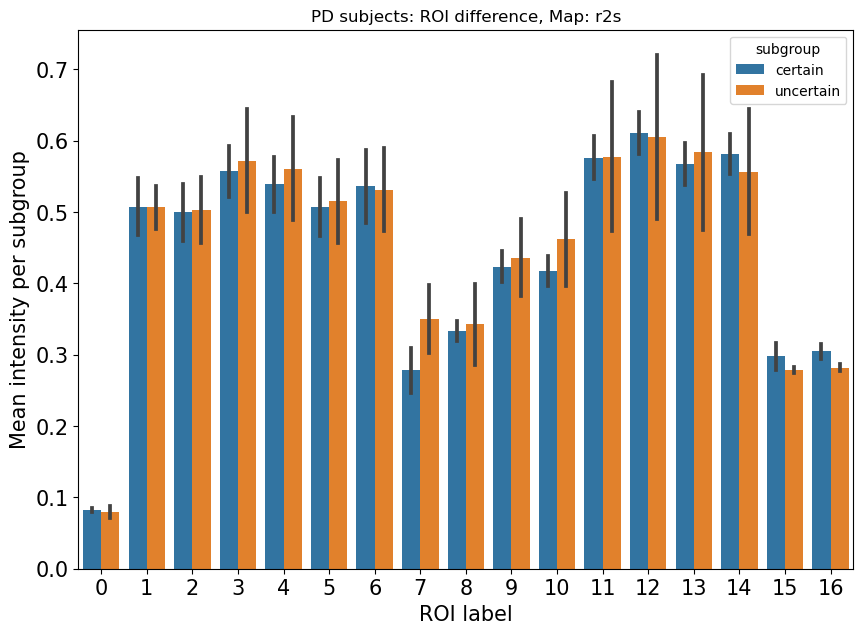

In [116]:
dfs_certain = pd.read_csv('xai_outs/stats_8subj_correct.csv')
dfs_certain = dfs_certain.loc[dfs_certain.group == 'PD']
dfs_certain['subgroup'] = 'certain'
dfs_uncertain = pd.read_csv('xai_outs/stats_5subjs_others.csv')
dfs_uncertain = dfs.loc[dfs.subject.isin(['sub-021', 'sub-042', 'sub-039'])] # correctly classified, close to 0.5 confidence score
dfs_uncertain['subgroup'] = 'uncertain'

map_type = 'r2s'
dfs_all = pd.concat([dfs_certain, dfs_uncertain], axis=0)
df_lab = dfs_all.loc[(dfs_all.map_type == map_type), :]
plt.figure(figsize=(10, 7))
sns.barplot(data=df_lab, x='label', y='mean', hue='subgroup', errorbar='se')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('ROI label', fontsize=15)
plt.ylabel('Mean intensity per subgroup', fontsize=15)
# plt.legend(fontsize=15)
plt.title(f'PD subjects: ROI difference, Map: {map_type}')
plt.show()

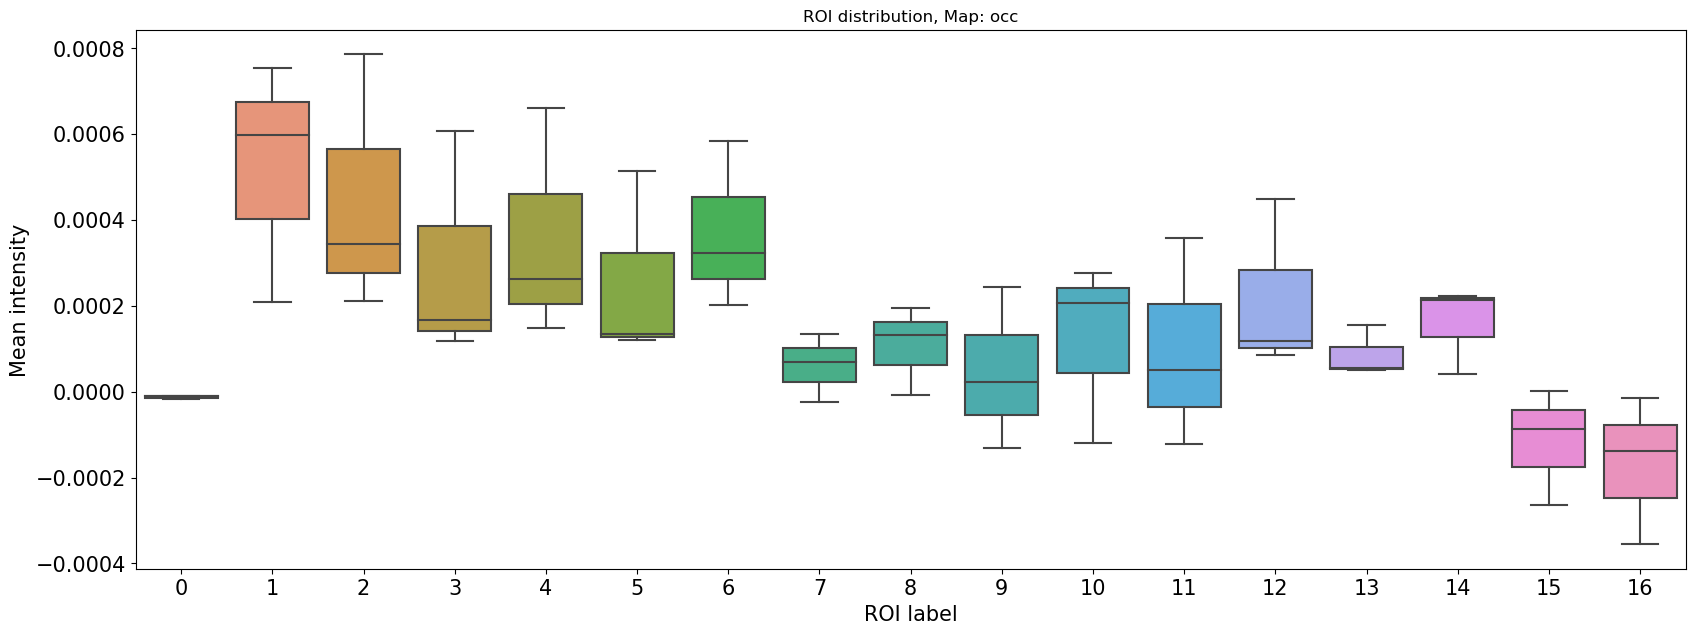

In [68]:
label = 3
map_type = 'occ'
df_lab = dfs_uncertain.loc[(dfs_uncertain.map_type == map_type), :] # & (dfs.map_type == map_type) (dfs.label == label) & 
df_lab
plt.figure(figsize=(20, 7))
sns.boxplot(data=df_lab, x='label', y='mean') #, hue='group') #, hue='map_type')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('ROI label', fontsize=15)
plt.ylabel('Mean intensity', fontsize=15)
# plt.legend(fontsize=15)
plt.title(f'ROI distribution, Map: {map_type}')
plt.show()

In [50]:
maps = ['r2s', 'occ', 'ig']
fos_type = 'mean'
f_oneway_stats = []
for map in maps: 
    for label in range(17):
        test_dict = {}
        df_lab = dfs.loc[(dfs.map_type == map) & (dfs.label == label), :]
        f_stat, p_value = f_oneway(df_lab.loc[df_lab.group == 'PD', fos_type].values, df_lab.loc[df_lab.group == 'HC', fos_type].values)
        test_dict['map'] = map
        test_dict['fos_type'] = fos_type
        test_dict['label'] = label
        test_dict['f_oneway'] = f_stat
        test_dict['p_value'] = p_value
        f_oneway_stats.append(test_dict)

In [57]:
df = pd.DataFrame(f_oneway_stats)

In [58]:
replace_dict = {1: 'left_red_nucleus',
                3: 'left_substantia_nigra',
                5: 'left_subthalamic_nucleus',
                7: 'left_caudate',
                9: 'left_putamen',
                11: 'left_globus_pallidus_externa',
                13: 'left_globus_pallidus_interna',
                15: 'left_thalamus',
                2: 'right_red_nucleus',
                4: 'right_substantia_nigra',
                6: 'right_subthalamic_nucleus',
                8: 'right_caudate',
                10: 'right_putamen',
                12: 'right_globus_pallidus_externa',
                14: 'right_globus_pallidus_interna',
                16: 'right_thalamus',}
df.label.replace(replace_dict, inplace=True)
# df.to_csv('xai_outs/f_oneway_results.csv')
df.loc[df.p_value <= 0.005, :].sort_values(by='p_value')

,map,fos_type,label,f_oneway,p_value
34,ig,mean,0,150.532214,0.000018
29,occ,mean,right_globus_pallidus_externa,62.538034,0.000217
18,occ,mean,left_red_nucleus,40.315682,0.000715
31,occ,mean,right_globus_pallidus_interna,31.841545,0.001328
25,occ,mean,right_caudate,26.276953,0.002165
47,ig,mean,left_globus_pallidus_interna,24.411281,0.002602
20,occ,mean,left_substantia_nigra,23.902338,0.002741
45,ig,mean,left_globus_pallidus_externa,23.820696,0.002764
19,occ,mean,right_red_nucleus,20.928885,0.003791
23,occ,mean,right_subthalamic_nucleus,20.216903,0.004120


In [60]:
df.loc[df.map == 'r2s'].sort_values(by='p_value')

,map,fos_type,label,f_oneway,p_value
12,r2s,mean,right_globus_pallidus_externa,12.548382,0.012184
14,r2s,mean,right_globus_pallidus_interna,11.746263,0.014018
3,r2s,mean,left_substantia_nigra,7.674527,0.032410
9,r2s,mean,left_putamen,5.885121,0.051447
8,r2s,mean,right_caudate,5.417305,0.058841
11,r2s,mean,left_globus_pallidus_externa,4.706601,0.073115
13,r2s,mean,left_globus_pallidus_interna,4.433884,0.079848
16,r2s,mean,right_thalamus,3.890644,0.096021
4,r2s,mean,right_substantia_nigra,3.833537,0.097974
6,r2s,mean,right_subthalamic_nucleus,2.579824,0.159357


In [24]:
dfs.to_csv('xai_outs/stats_8subj_correct.csv')

In [12]:
dfs = pd.concat([df, df], axis=0)
dfs.reset_index(drop=True, inplace=True)
dfs

,label,subject,mean,std,median,max,min,iqr,map_type,group
0,0,sub-015,0.076171,0.167551,0.000000,1.000000,0.000000,0.000000,R2s,PD
1,1,sub-015,0.482413,0.054449,0.485569,0.612388,0.344587,0.073327,R2s,PD
2,2,sub-015,0.496289,0.049496,0.497482,0.595219,0.315454,0.054686,R2s,PD
3,3,sub-015,0.501879,0.080084,0.493421,0.772590,0.300362,0.103222,R2s,PD
4,4,sub-015,0.488259,0.072331,0.487200,0.814420,0.272929,0.096081,R2s,PD
5,5,sub-015,0.475764,0.050556,0.468585,0.622872,0.377056,0.054226,R2s,PD
6,6,sub-015,0.479547,0.052669,0.482360,0.590177,0.357227,0.060052,R2s,PD
7,7,sub-015,0.338203,0.098976,0.339967,0.995558,0.000000,0.091938,R2s,PD
8,8,sub-015,0.312351,0.109459,0.321444,1.000000,0.000000,0.112033,R2s,PD
9,9,sub-015,0.391403,0.077651,0.388681,0.795950,0.000000,0.105278,R2s,PD


In [63]:
def mask_atlas(subject:str, group: str, save=True):
    anat_path = Path(f'/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI/{subject}/Results/Masks')
    # read brain mask
    brain_mask = sitk.GetArrayFromImage(sitk.ReadImage(str(anat_path/f'{subject}_brain_mask_mtsat_w.nii')))

    x_min, x_max, y_min, y_max, z_min, z_max = crop_img(brain_mask, return_dims=True)

    # read atlas
    atlas = sitk.ReadImage(str(anat_path/f'inv_reoriented_{subject}_mT1w_{group}_pd25_PD25-subcortical-1mm_uint8.nii'))
    atlas_nda = sitk.GetArrayFromImage(atlas)
    # crop atlas
    atlas_nda_c = atlas_nda[x_min:x_max, y_min:y_max, z_min:z_max] 
    if save:
        save_sitk_from_nda(atlas_nda_c,
                           anat_path/f'{subject}_PD25-subcortical-1mm_cropped.nii',
                           atlas)
    else:
        return atlas_nda_c

def get_atlas_nda(subject, group):

    # crop PD25 atlas as brain mask and save
    mask_atlas(subject, group)
    og_path = Path(f"/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI/{subject}/Results/")
    
    # set atlas path
    pd25_path = og_path / f'Masks/{subject}_PD25-subcortical-1mm_cropped.nii'
    
    # create tio subject and preprocess
    preprocess = tio.Compose(
            [   tio.ToCanonical(),
                tio.CropOrPad(180, padding_mode='minimum')
            ]
        )
    atlas_tiosubj_o = tio.Subject(image=tio.ScalarImage(pd25_path))
    atlas_tiosubj_p = preprocess(atlas_tiosubj_o)
    atlas_tiosubj_nda = atlas_tiosubj_p['image'][tio.DATA].cpu().numpy()[0]

    return atlas_tiosubj_nda
    